# Deployment - Watson ML

*A notebook, where final models can be deployed.*

## Settings

In [1]:
!pip install watson-machine-learning-client

In [2]:
%reset -f

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import scipy 

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input

from tensorflow import keras as K
from tensorflow.keras import layers

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [4]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='*****************', project_access_token='**********************************')
pc = project.project_context


## Load data

In [5]:
# loading profiles.csv
f = project.get_file('profiles.csv')
profiles_raw = pd.read_csv(f)
profiles_raw.head()

,UID,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range,Challenge,Closeness,Curiosity,Excitement,...,Love,Practicality,Self-expression,Stability,Structure,Conservation,Openness to change,Hedonism,Self-enhancement,Self-transcendence
0,89168924,0.672358,0.515518,0.202560,0.388493,0.952090,0.449133,0.491036,0.373575,0.361041,...,0.669498,0.527576,0.765530,0.314229,0.463151,0.362166,0.480516,0.437073,0.592248,0.485292
1,74580436,0.769577,0.442860,0.063138,0.152624,0.998766,0.792551,0.712586,0.726484,0.940915,...,0.964348,0.991403,0.998430,0.923608,0.908561,0.743416,0.608181,0.473193,0.882402,0.857386
2,52536879,0.445128,0.776801,0.899640,0.881138,0.706536,0.857511,0.842577,0.751038,0.759625,...,0.899586,0.529881,0.791273,0.899268,0.607543,0.917088,0.715703,0.825515,0.962015,0.753915
3,17243213,0.707812,0.725007,0.057476,0.296220,0.990815,0.551724,0.447475,0.519926,0.487398,...,0.542529,0.546406,0.840359,0.770971,0.740211,0.411759,0.566608,0.215377,0.478906,0.604419
4,278662460,0.659059,0.788241,0.708605,0.238162,0.566861,0.686579,0.331890,0.248036,0.528839,...,0.247863,0.619599,0.413212,0.747458,0.800460,0.741150,0.436434,0.685875,0.959131,0.235388


In [6]:
profiles_raw.drop(columns=['UID'], inplace=True)
profiles_raw.head()

,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range,Challenge,Closeness,Curiosity,Excitement,Harmony,...,Love,Practicality,Self-expression,Stability,Structure,Conservation,Openness to change,Hedonism,Self-enhancement,Self-transcendence
0,0.672358,0.515518,0.202560,0.388493,0.952090,0.449133,0.491036,0.373575,0.361041,0.673358,...,0.669498,0.527576,0.765530,0.314229,0.463151,0.362166,0.480516,0.437073,0.592248,0.485292
1,0.769577,0.442860,0.063138,0.152624,0.998766,0.792551,0.712586,0.726484,0.940915,0.769730,...,0.964348,0.991403,0.998430,0.923608,0.908561,0.743416,0.608181,0.473193,0.882402,0.857386
2,0.445128,0.776801,0.899640,0.881138,0.706536,0.857511,0.842577,0.751038,0.759625,0.892253,...,0.899586,0.529881,0.791273,0.899268,0.607543,0.917088,0.715703,0.825515,0.962015,0.753915
3,0.707812,0.725007,0.057476,0.296220,0.990815,0.551724,0.447475,0.519926,0.487398,0.721506,...,0.542529,0.546406,0.840359,0.770971,0.740211,0.411759,0.566608,0.215377,0.478906,0.604419
4,0.659059,0.788241,0.708605,0.238162,0.566861,0.686579,0.331890,0.248036,0.528839,0.559211,...,0.247863,0.619599,0.413212,0.747458,0.800460,0.741150,0.436434,0.685875,0.959131,0.235388


In [7]:
profiles_raw.dropna(axis=0, inplace=True)
len(profiles_raw)

5437

In [8]:
big5traits = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Emotional range', 'Self-transcendence']
big5traits_class = big5traits.copy()
big5traits_class.append('Class')

## Autoencoder

In [9]:
def Auto_Encoder(input_shape, output_dim, activation='relu', dropout=0.13, summary=False):
    
    Input_Layer = Input(shape=input_shape)
    
    # Encoding
    Y = Dense(15, activation=activation)(Input_Layer)
    Y = Dropout(dropout)(Y)
    
    Y = Dense(8, activation=activation)(Y)
    Y = Dropout(dropout)(Y)
    
    Y = Dense(4, activation=activation)(Y)
    Y = Dropout(dropout)(Y)
    
    # Bottleneck layer
    Encoder = Dense(output_dim, activation=activation, name='bottleneck')(Y)
    
    # Decoding
    Y = Dense(4, activation=activation)(Y)
    Y = Dropout(dropout)(Y)
    
    Y = Dense(8, activation=activation)(Encoder)
    Y = Dropout(dropout)(Y)
    
    Y = Dense(15, activation=activation)(Y)
    Y = Dropout(dropout)(Y)
    
    Output_Layer = Dense(input_shape[0], activation=activation)(Y)
    
    model = Model(inputs=Input_Layer, outputs=Output_Layer)
    
    if summary:
        print(model.summary())
        
    return model

In [10]:
new_dim = 2
CHOSEN_TRAITS = ['F_{:d}'.format(i) for i in range(new_dim)]
CHOSEN_TRAITS

['F_0', 'F_1']

In [11]:
autoencoder = Auto_Encoder((22, ), new_dim, activation='sigmoid',summary=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 22)                0         
_________________________________________________________________
dense (Dense)                (None, 15)                345       
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)      

In [12]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.MSE)

In [13]:
X = profiles_raw.to_numpy()
X = np.round(X, 3)
X

array([[0.672, 0.516, 0.203, ..., 0.437, 0.592, 0.485],
       [0.77 , 0.443, 0.063, ..., 0.473, 0.882, 0.857],
       [0.445, 0.777, 0.9  , ..., 0.826, 0.962, 0.754],
       ...,
       [0.542, 0.319, 0.17 , ..., 0.561, 0.372, 0.836],
       [0.643, 0.743, 0.12 , ..., 0.477, 0.687, 0.86 ],
       [0.585, 0.481, 0.468, ..., 0.66 , 0.876, 0.638]])

In [14]:
autoencoder.fit(X, X,
            epochs=150,
            batch_size=128,
            shuffle=True,
            validation_split=0.2)

Train on 4349 samples, validate on 1088 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/150
4349/4349 [==============================] - 5s 1ms/sample - loss: 0.0873 - val_loss: 0.0830
Epoch 2/150
4349/4349 [==============================] - 1s 284us/sample - loss: 0.0783 - val_loss: 0.0785
Epoch 3/150
4349/4349 [==============================] - 1s 215us/sample - loss: 0.0747 - val_loss: 0.0773
Epoch 4/150
4349/4349 [==============================] - 0s 100us/sample - loss: 0.0732 - val_loss: 0.0771
Epoch 5/150
4349/4349 [==============================] - 1s 237us/sample - loss: 0.0726 - val_loss: 0.0773
Epoch 6/150
4349/4349 [==============================] - 1s 118us/sample - loss: 0.0724 - val_loss: 0.0774
Epoch 7/150
4349/4349 [==============================] - 0s 96us/sample - loss: 0.0723 - val_loss: 0.0775
Epoch 8/150
4349/4349 [==============================] - 3s 657us/sample - loss: 0.0721 - val_loss: 0.0777
Epoch 9/150
4349/4349 [============================

In [15]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)

data_red = encoder.predict(X)

profiles = pd.DataFrame(data_red, columns=CHOSEN_TRAITS)
profiles.head()

,F_0,F_1
0,0.120175,0.186156
1,0.584725,0.111856
2,0.582034,0.112137
3,0.235181,0.156660
4,0.117005,0.187330


In [16]:
profiles.describe()

,F_0,F_1
count,5.437000e+03,5437.000000
mean,1.535124e-01,0.376339
std,2.151939e-01,0.275351
min,2.980232e-08,0.110041
25%,2.601743e-04,0.147140
50%,1.846415e-02,0.276002
75%,2.910177e-01,0.537530
max,6.021039e-01,0.894595


## Auxiliary

In [18]:
def Davies_Bouldin_index(df, cats, cluster_cores, distance, order=1):
    
    n = len(cluster_cores)
    sigmas = np.zeros(n)
    
    # average intra-cluster distances
    for i, cc in enumerate(cluster_cores):
        sigmas[i] = np.mean(df[df[cats] == i].apply(lambda row: distance(row[:-1], cluster_cores[i], k=order), axis=1))
    
    # max intra-inter relations
    dists = [np.max([(sigmas[i] + sigmas[j])/distance(cluster_cores[i], cluster_cores[j], order) for j in range(n) if i != j]) for i in range(n)]
    return np.mean(dists)
    
    
def Distribution_distance(x, mean, cov):
    n = len(mean)
    stds = np.array([[cov[i, j] for j in range(n) if i == j][0] for i in range(n)])
    
    return scipy.linalg.norm(np.divide(np.abs(x-mean), stds))

def Mahalanobis_distance(x, mean, inv_cov):
    return (x-mean).T@inv_cov@(x-mean)

def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))

def minmax_scaling(z):
    return (z - np.min(z))/(np.max(z) - np.min(z))

def Davies_Bouldin_Mahalanobis(df, cats, cluster_cores, inv_cov):
    
    n = len(cluster_cores)
    sigmas = np.zeros(n)
    if len(inv_cov.shape) == 2:
        ic = inv_cov.copy()
        inv_cov = np.zeros((n, ic.shape[0], ic.shape[1]))
        for i in range(n):
            inv_cov[i] = ic.copy()
            
    # average intra-cluster distances
    for i, cc in enumerate(cluster_cores):
        sigmas[i] = np.mean(df[df[cats] == i].apply(lambda row: Mahalanobis_distance(row[:-1], cc, inv_cov[i]), axis=1))
    
    # max intra-inter relations
    dists = [np.max([(sigmas[i] + sigmas[j])/Mahalanobis_distance(cluster_cores[i], cluster_cores[j], inv_cov[j]) for j in range(n) if i != j]) for i in range(n)]
    return np.mean(dists)

def boxplot(param, cats, data, ax=None):
    if not ax:
        fig, (ax) = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle('A box plot', fontsize=14)

    sns.boxplot(x=cats, y=param, data=data,  ax=ax, orient='v')
    ax.set_xlabel("{:s}".format(param),size = 12,alpha=0.8)
    ax.set_ylabel(param,size = 12,alpha=0.8)
    
def radar_plot(data, traits, COLOR='coral', 
               title=None, ax=None, labeled=None, 
               drop_xticks=False, drop_yticks=False):
    N = len(traits)
    # arclength from 0 up to this point (i)
    angles = [2*np.pi*i/N for i in range(N)]
    
    if not ax:
        fig = plt.figure(figsize=(10, 10))
        ax = plt.subplot(111, polar=True)

    # structure
    ax.set_xticks(angles)
    plt.xticks(angles, traits)
    ax.set_yticks([0, 0.2, 0.5, 0.8, 1.0])
    ax.set_thetalim(0, 2*np.pi)
    ax.tick_params(direction='out', labelsize=12, colors='black',
               grid_color='dimgrey', grid_alpha=0.8, labelrotation='auto')
    
    if drop_xticks:
        plt.tick_params(
                axis='both',    
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
    
    if drop_yticks:
        ax.set_yticks([])

    # duplicating first point to close the circle
    data = np.append(data, data[0])
    angles.append(angles[0])
    
    if title:
        ax.set_title(title, fontsize=12)
    
    ax.plot(angles, data, color=COLOR, linewidth=3, label=labeled)
    ax.plot(angles, data, color=COLOR, linewidth=5, alpha=0.1)
    ax.plot(angles, data, color=COLOR, linewidth=8, alpha=0.5)
    ax.fill(angles, data, alpha=0.23, color=COLOR);
    
    
def silhouette_evaluation(df, plot=True, distance='l2',samples_per_class=50, cmap='hsv', verbose=True):
    
    X = df.to_numpy()
    labels = X[:, -1]
    X = X[:, :-1]
    cluster_codes, cluster_lengths = np.unique(labels, return_counts=True)
    
    sil = silhouette_samples(X, labels, metric=distance)
    sil_score = silhouette_score(X, labels, metric=distance)
    
    res_df = pd.DataFrame(np.stack([labels, sil], axis=1), columns=['Class', 'Silhouette'])
    sil_means = res_df.groupby('Class').mean()
    
    if verbose:
        print('Silhouette quality of each cluster:')
        print(sil_means)
        print('Silhouette score of the clustering is: ', sil_score)
    if plot:
        sample_df = pd.DataFrame(columns=['Class', 'Silhouette'])
        ax_labels = []
        
        for cat in cluster_codes:
            sample_df = pd.concat([sample_df, res_df[res_df['Class'] == cat].sample(samples_per_class)])
            ax_labels.append("Cluster {:d}".format(int(cat)))
            
        # Create a color palette:
        my_palette = plt.cm.get_cmap(cmap, len(cluster_codes))
        sam = sample_df.to_numpy()
        sam_class = sam[:, 0]
        sam_sil = sam[:, 1]
        
        fig, ax = plt.subplots(figsize=(15, 20))
        plt.title('Silhouette values', fontsize=20)
        
        plt.barh(y=np.arange(0, len(sam_sil)), width=sam_sil, edgecolor='k',
                 color=my_palette(sam_class/np.max(sam_class)))
        
        ax.set_yticks(cluster_codes*samples_per_class + samples_per_class//2)
        ax.set_yticklabels(ax_labels, fontsize=13, rotation='vertical')
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Silhouette', fontsize=15)              
        
        
    return res_df, sil_means, sil_score

def Lk_norm(point1, point2, k=2):
    
    n = len(point1)
    return np.power(np.sum([np.abs(point1[i] - point2[i])**k for i in range(n)]), 1/k)

## K means

### Model

In [19]:
data = profiles.to_numpy()
data.shape

(5437, 2)

In [20]:
start_time = time.time()
kmeans = KMeans(n_clusters=4, random_state=0, algorithm='auto',
               max_iter=500, n_init=50).fit(data)
print("Took {:.2f} seconds.".format(time.time() - start_time))

Took 0.96 seconds.


In [21]:
cat = kmeans.labels_
df = profiles.copy()
df_raw = profiles_raw.copy()
df['Class'] = cat
df_raw['Class'] = cat
df.head()

,F_0,F_1,Class
0,0.120175,0.186156,1
1,0.584725,0.111856,2
2,0.582034,0.112137,2
3,0.235181,0.156660,1
4,0.117005,0.187330,1


### Evaluation

/opt/conda/envs/Python36/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


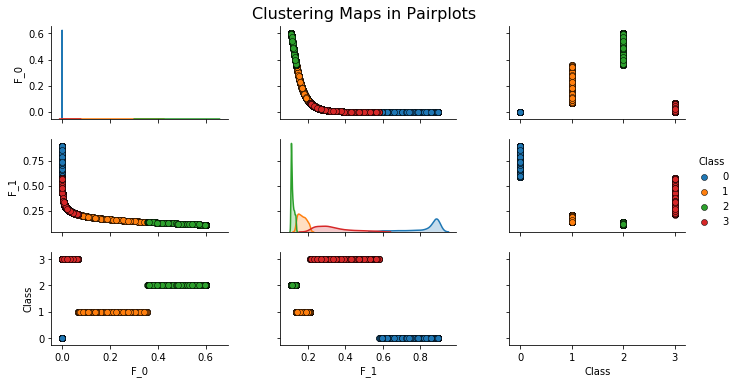

In [22]:
pp = sns.pairplot(df, size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True), 
                 hue='Class')

fig = pp.fig 

fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Clustering Maps in Pairplots', fontsize=16)

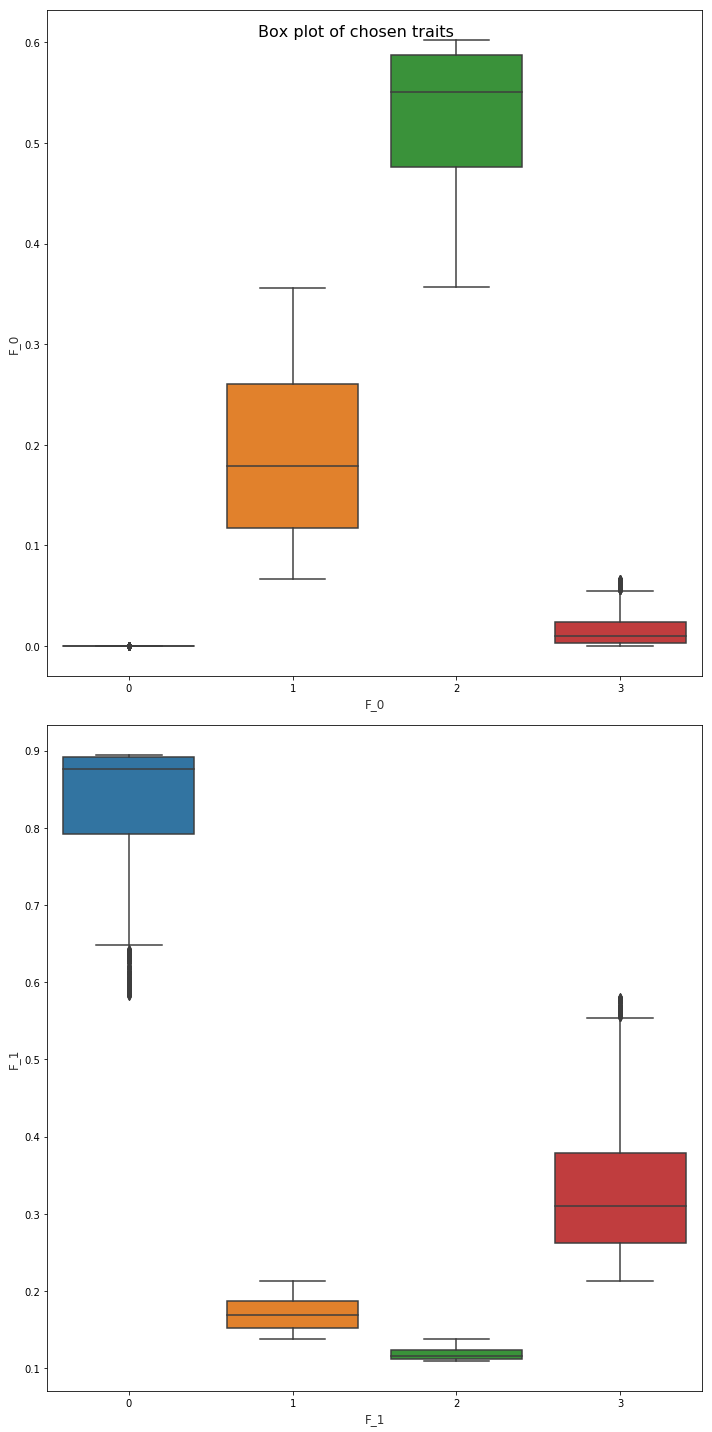

In [23]:
fig, axs = plt.subplots(len(df.columns[:-1]), 1, figsize=(10, 20))
fig.suptitle('Box plot of chosen traits', fontsize=16)

for i, trait in enumerate(df.columns[:-1]):
    boxplot(trait, 'Class', df, axs[i])
    
plt.tight_layout()

In [24]:
cluster_cores = kmeans.cluster_centers_
cores = pd.DataFrame(cluster_cores, columns=df.columns[:-1])
cores

,F_0,F_1
0,0.000008,0.830041
1,0.190004,0.170677
2,0.525082,0.118350
3,0.015918,0.332253


In [25]:
Davies_Bouldin_index(df, 'Class', cluster_cores, Lk_norm)

0.43952352390182775

In [26]:
raw_cores = df_raw.groupby('Class').mean()
raw_cores

,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range,Challenge,Closeness,Curiosity,Excitement,Harmony,...,Love,Practicality,Self-expression,Stability,Structure,Conservation,Openness to change,Hedonism,Self-enhancement,Self-transcendence
Class,,,,,,,,,,,,,,,,,,,,,
0,0.840321,0.675435,0.442122,0.361957,0.412708,0.207887,0.173854,0.377030,0.122661,0.194385,...,0.143889,0.232035,0.208759,0.317414,0.472449,0.171216,0.302426,0.133983,0.183124,0.159718
1,0.613347,0.657609,0.338097,0.522469,0.600346,0.649553,0.497925,0.645016,0.410543,0.646944,...,0.438474,0.477914,0.537659,0.676803,0.683593,0.524463,0.552826,0.384444,0.561928,0.442039
2,0.480533,0.534420,0.319097,0.538916,0.666032,0.748835,0.684695,0.757100,0.695028,0.786929,...,0.637595,0.685193,0.759485,0.783867,0.699090,0.697096,0.724045,0.689053,0.782361,0.610770
3,0.697560,0.659059,0.341191,0.433458,0.538667,0.491112,0.329954,0.531246,0.265085,0.437991,...,0.288492,0.379154,0.368288,0.500646,0.614733,0.351262,0.436680,0.252448,0.408608,0.302994


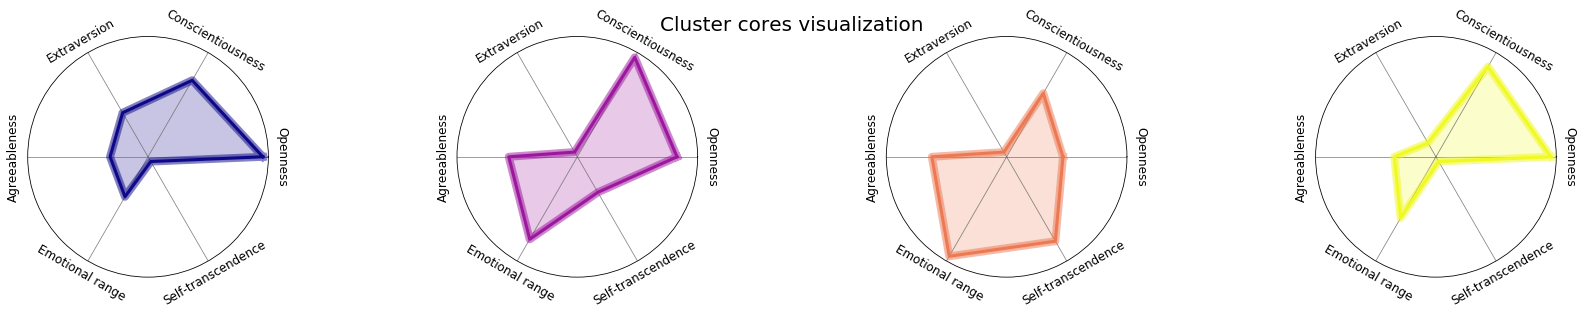

In [27]:
# Create a color palette:
my_palette = plt.cm.get_cmap("plasma", len(cores.index))

raw_cores = df_raw.groupby('Class').mean()

nb_clusters = len(cores)
fig = plt.figure(figsize=(24, 16))
fig.suptitle('Cluster cores visualization', fontsize=20)

for i in range(nb_clusters):
    axs = plt.subplot(4, 4, i+1, polar=True)
    radar_plot(data = raw_cores[big5traits].to_numpy()[i], traits=big5traits, 
               COLOR=my_palette(i), ax=axs, drop_yticks=True, drop_xticks=False)
    
plt.tight_layout()

Silhouette quality of each cluster:
       Silhouette
Class            
0.0      0.802078
1.0      0.512209
2.0      0.739824
3.0      0.591975
Silhouette score of the clustering is:  0.6619821340508263


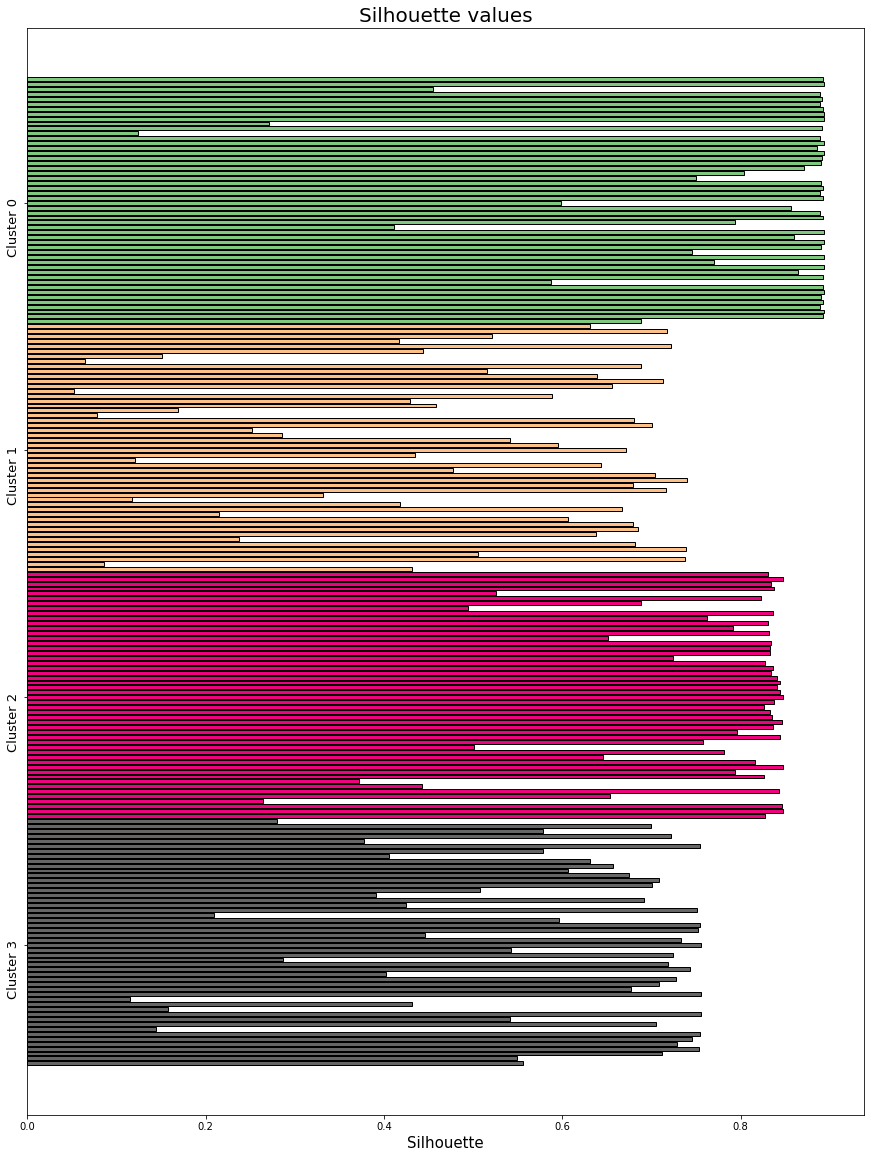

In [28]:
r = silhouette_evaluation(df, distance='l1', samples_per_class=50, cmap='Accent')

## Saving results

In [29]:
project.save_data('clustered_22d.csv', df_raw.to_csv(index=False), overwrite=True)
project.save_data('clustered_2d.csv', df.to_csv(index=False), overwrite=True)

{'file_name': 'clustered_2d.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'personalityampstreaming-donotdelete-pr-a8tibzhln8fz93',
 'asset_id': 'ecc3a4c4-740b-46ce-afe6-209144fb781b'}

## Deployment

In [10]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

# Credentials from Watson Machine Learning service
wml_credentials = {
  "apikey": "*****************",
  "iam_apikey_description": "*****************",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "*****************"
  "instance_id": "*****************",
  "url": "https://eu-gb.ml.cloud.ibm.com"
}

In [11]:
client = WatsonMachineLearningAPIClient(wml_credentials)
instance_details = client.service_instance.get_details()

In [12]:
client.deployments.list()

------------------------------------  -----------------  ------  --------------  ------------------------  -----------------  -------------
GUID                                  NAME               TYPE    STATE           CREATED                   FRAMEWORK          ARTIFACT TYPE
a4d32f42-e602-4a76-87a9-61cf70c70c6d  Kmeans clustering  online  DEPLOY_SUCCESS  2020-08-04T14:11:35.116Z  scikit-learn-0.20  model
6a96eebc-8b9c-4905-a3db-47da532a90fa  Encoder_v1         online  UNKNOWN         2020-08-04T14:10:14.645Z  tensorflow-1.15    model
------------------------------------  -----------------  ------  --------------  ------------------------  -----------------  -------------


In [34]:
client.deployments.delete("726d0f57-6b51-404d-959f-de7a115afc6f")

'SUCCESS'

### Encoder

In [35]:
encoder.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.MSE)

In [36]:
encoder.save("encoder_v1.h5")

In [37]:
!ls -lah

total 40K
drwxr-x--- 2 dsxuser dsxuser 4.0K Aug  4 14:09 .
drwx------ 1 dsxuser dsxuser 4.0K Aug  4 13:19 ..
-rw-r----- 1 dsxuser dsxuser  25K Aug  4 14:09 encoder_v1.h5


In [38]:
!tar -zcvf encoder_v1.tgz encoder_v1.h5

encoder_v1.h5


In [39]:
encoder_props = {client.repository.ModelMetaNames.AUTHOR_NAME: "Vadym_H", 
               client.repository.ModelMetaNames.NAME: "Encoder_v1",
               client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
               client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.15" ,
               client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{"name": "keras", "version": "2.1.6"}]
              }

In [40]:
published_encoder = client.repository.store_model(model="encoder_v1.tgz", meta_props=encoder_props)

In [41]:
published_encoder_uid = published_encoder["metadata"]["guid"]
encoder_details = client.repository.get_details(published_encoder_uid)
published_encoder_uid

'b362d407-e582-4277-9bbf-c3aaede65d5a'

In [42]:
encoder_deployment = client.deployments.create(artifact_uid=published_encoder_uid, name="Encoder_v1")



#######################################################################################

Synchronous deployment creation for uid: 'b362d407-e582-4277-9bbf-c3aaede65d5a' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS.............
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='6a96eebc-8b9c-4905-a3db-47da532a90fa'
------------------------------------------------------------------------------------------------




### Kmeans

In [43]:
data.shape

(5437, 2)

In [44]:
published_kmeans = client.repository.store_model(model=kmeans, meta_props={'name':'Kmeans clustering based on reduced data'})

In [45]:
import json
published_kmeans_uid = client.repository.get_model_uid(published_kmeans)
kmeans_details = client.repository.get_details(published_kmeans_uid)

#print(json.dumps(model_details, indent=2))

In [46]:
kmeans_deployment = client.deployments.create(published_kmeans_uid, 'Kmeans clustering')



#######################################################################################

Synchronous deployment creation for uid: '2c291cee-a9ee-47d1-a981-ce84ed68b9f7' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='a4d32f42-e602-4a76-87a9-61cf70c70c6d'
------------------------------------------------------------------------------------------------




### Deployments list

In [47]:
#client.deployments.get_details()

In [48]:
client.deployments.list()

------------------------------------  -----------------  ------  --------------  ------------------------  -----------------  -------------
GUID                                  NAME               TYPE    STATE           CREATED                   FRAMEWORK          ARTIFACT TYPE
a4d32f42-e602-4a76-87a9-61cf70c70c6d  Kmeans clustering  online  DEPLOY_SUCCESS  2020-08-04T14:11:35.116Z  scikit-learn-0.20  model
6a96eebc-8b9c-4905-a3db-47da532a90fa  Encoder_v1         online  DEPLOY_SUCCESS  2020-08-04T14:10:14.645Z  tensorflow-1.15    model
------------------------------------  -----------------  ------  --------------  ------------------------  -----------------  -------------


In [49]:
base_link = "https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/05c04464-6f99-4eb2-97e0-3f1cac001764/deployments/"
scoring_endpoint_encoder = base_link + "6a96eebc-8b9c-4905-a3db-47da532a90fa" + "/online"
scoring_endpoint_kmeans = base_link + "a4d32f42-e602-4a76-87a9-61cf70c70c6d" + "/online"

In [50]:
print("Encoder: ", scoring_endpoint_encoder)
print("Kmeans: ", scoring_endpoint_kmeans)

Encoder:  https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/05c04464-6f99-4eb2-97e0-3f1cac001764/deployments/6a96eebc-8b9c-4905-a3db-47da532a90fa/online
Kmeans:  https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/05c04464-6f99-4eb2-97e0-3f1cac001764/deployments/a4d32f42-e602-4a76-87a9-61cf70c70c6d/online


In [51]:
print("Encoder: ", scoring_endpoint_encoder)
print("Kmeans: ", scoring_endpoint_kmeans)

Encoder:  https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/05c04464-6f99-4eb2-97e0-3f1cac001764/deployments/6a96eebc-8b9c-4905-a3db-47da532a90fa/online
Kmeans:  https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/05c04464-6f99-4eb2-97e0-3f1cac001764/deployments/a4d32f42-e602-4a76-87a9-61cf70c70c6d/online


In [150]:
space_guid = "05c04464-6f99-4eb2-97e0-3f1cac001764"
encoder_guid = "809062e6-5cc3-46c2-98a3-a7cd68ae1626"
kmeans_guid = "b1334231-2a8e-4e4b-847b-8f1d68b47e56"

## Check scoring

In [52]:
profiles_raw.iloc[42].to_numpy()

array([0.50975516, 0.80323022, 0.50754827, 0.55540762, 0.78144845,
       0.70499645, 0.60309413, 0.48089569, 0.80753924, 0.66633749,
       0.66887864, 0.82673841, 0.7208548 , 0.76193571, 0.89278253,
       0.52162718, 0.51708193, 0.61525182, 0.7193755 , 0.5556906 ,
       0.72649778, 0.53144463])

In [53]:
row = np.random.uniform(size=22)
row = np.round(row, 3)
row = row.tolist()
row

[0.092,
 0.017,
 0.507,
 0.323,
 0.815,
 0.463,
 0.594,
 0.629,
 0.135,
 0.084,
 0.893,
 0.877,
 0.112,
 0.903,
 0.482,
 0.371,
 0.158,
 0.808,
 0.861,
 0.623,
 0.408,
 0.132]

In [54]:
encoder_scoring_payload = {'values': [row]}
encoder_prediction = client.deployments.score(scoring_endpoint_encoder, encoder_scoring_payload)

In [55]:
encoder_prediction['values'][0]

[0.29357796907424927, 0.1467781960964203]

In [56]:
kmeans_scoring_payload = {'values': encoder_prediction['values']}
kmeans_prediction = client.deployments.score(scoring_endpoint_kmeans, kmeans_scoring_payload)
kmeans_prediction['values'][0]

[1]

***Comment:*** It may be observed that deployments work and can be accessed following the procedure above.

---